In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch
import numpy as np
import pandas as pd
from IPython.display import display, Math
from enum import *
import time
from sklearn import svm

startInstantTime = time.time()

In [2]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "InformacionEjercicioClasificacion.txt"
nombreArchivoDataset = "DatasetClasificacion.csv"
tasaAprendizaje = 0.001
tiempoPausaAnimacion = 0.01

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer = None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

In [4]:
#Se controla por medio de estados la clasificacion de todas las muestras de una clase dada
class EstadosClasificacion(Enum):
    estado1 = "Todas las muestras de la clase 1 están efectivamente en la clase 1"
    estado2 = "Todas las muestras de la clase 2 están efectivamente en la clase 2"
    estado3 = "Se tiene al menos una muestra en la clase equivocada"

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplano, punto, numeroDimensiones):
    return np.dot(listaCoeficientesHiperplano[0:numeroDimensiones], punto) + listaCoeficientesHiperplano[numeroDimensiones]

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
    
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

def crearTextoEcuacionHiperplano(listaCoeficientesHiperplano, numeroDimensiones):
    diccionarioCoeficientesNoNulos = {}
    for indice in range(numeroDimensiones + 1):
        if listaCoeficientesHiperplano[indice] != 0.0:
            diccionarioCoeficientesNoNulos[indice] = listaCoeficientesHiperplano[indice]
    
    textoEcuacionHiperplano = ''
    nuevoIndiceCoeficienteNoNulo = 0
    if numeroDimensiones <= 3:
        for indice in diccionarioCoeficientesNoNulos.keys():
            if nuevoIndiceCoeficienteNoNulo == 0:
                if diccionarioCoeficientesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'' + chr(120 + indice)
                elif diccionarioCoeficientesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-' + chr(120 + indice)
                else:
                    textoEcuacionHiperplano = r'{}'.format(diccionarioCoeficientesNoNulos[indice]) + chr(120 + indice)
            elif nuevoIndiceCoeficienteNoNulo == len(diccionarioCoeficientesNoNulos.keys()) - 1:
                if indice == numeroDimensiones:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice])
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice]))
                else:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == 1.0:
                            textoEcuacionHiperplano += ' + ' + chr(120 + indice)
                        else:
                            textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice]) + chr(120 + indice)
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == -1.0:
                            textoEcuacionHiperplano += ' - ' + chr(120 + indice)
                        else:
                            textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + chr(120 + indice)
            else:
                if diccionarioCoeficientesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + ' + chr(120 + indice)
                    else:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice]) + chr(120 + indice)
                elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' - ' + chr(120 + indice)
                    else:
                        textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + chr(120 + indice)
            nuevoIndiceCoeficienteNoNulo += 1
    else:
        for indice in diccionarioCoeficientesNoNulos.keys():
            if nuevoIndiceCoeficienteNoNulo == 0:
                if diccionarioCoeficientesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'x_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-x_{' + str(indice + 1) + '}'
                else:
                    textoEcuacionHiperplano = r'{}x'.format(listaCoeficientesHiperplano[indice]) + '_{' + str(indice + 1) + '}'
            elif nuevoIndiceCoeficienteNoNulo == len(diccionarioCoeficientesNoNulos.keys()) - 1:
                if indice == numeroDimensiones:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice])
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice]))
                else:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == 1.0:
                            textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                        else:
                            textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == -1.0:
                            textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                        else:
                            textoEcuacionHiperplano += ' - {}x'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + '_{' + str(indice + 1)  + '}'
            else:
                if diccionarioCoeficientesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' - {}x'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + '_{' + str(indice + 1) + '}'
            nuevoIndiceCoeficienteNoNulo += 1
    textoEcuacionHiperplano += ' = 0'
    return textoEcuacionHiperplano

def crearTextoVector(vector, numeroDimensiones):
    textoVector = r'\left( '
    for indice in range(numeroDimensiones):
        if indice == numeroDimensiones - 1:
            textoVector += str(vector[indice])
        else:
            textoVector += str(vector[indice]) + ', '
    textoVector += r' \right)'
    return textoVector

In [5]:
def actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoInicial, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones):
    listaCoeficientesHiperplanoActualizado = listaCoeficientesHiperplanoInicial
    puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
    valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplanoActualizado, puntoMuestraSeleccionado, numeroDimensiones)
    if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
        if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
            for indice in range(numeroDimensiones):
                listaCoeficientesHiperplanoActualizado[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
            listaCoeficientesHiperplanoActualizado[numeroDimensiones] += tasaAprendizaje
        elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
            for indice in range(numeroDimensiones):
                listaCoeficientesHiperplanoActualizado[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
            listaCoeficientesHiperplanoActualizado[numeroDimensiones] -= tasaAprendizaje
    return listaCoeficientesHiperplanoActualizado

def verificarMuestrasClasificadasEnUnaSolaClase(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClaseObjetivo, numeroDimensiones):
    clasePuntoActual = nombreClaseObjetivo
    clasePuntoAnterior = nombreClaseObjetivo
    for punto in muestraPuntosPorClases[nombreClaseObjetivo]:
        clasePuntoAnterior = clasePuntoActual
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplano, punto, numeroDimensiones)
        if valorPunto == 0.0:
            return EstadosClasificacion.estado3
        elif np.sign(valorPunto) == 1.0:
            clasePuntoActual = nombreClase1
        else:
            clasePuntoActual = nombreClase2
        if clasePuntoActual != clasePuntoAnterior:
            return EstadosClasificacion.estado3
    
    if clasePuntoActual == nombreClase1:
        return EstadosClasificacion.estado1
    elif clasePuntoActual == nombreClase2:
        return EstadosClasificacion.estado2
    return EstadosClasificacion.estado3

def verificarClasificacionCorrecta(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, numeroDimensiones):
    revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1, numeroDimensiones)
    revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2, numeroDimensiones)
    return revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value

def algoritmoPerceptronSimple(listaCoeficientesHiperplanoInicial, listaCoeficientesHiperplanoSeparacionMaxima, listaVectoresSoporte, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones):
    listaCoeficientesHiperplanoActualizado = listaCoeficientesHiperplanoInicial
    clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2, numeroDimensiones)
    numeroPasos = 0
    if numeroDimensiones == 1:
        plt.ion()
        while clasificacionCompletada == False:
            plt.clf()
            listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones)

            listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
            listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
            valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
            valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
            valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
            valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
            minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
            maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1

            plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
            plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
            plt.axvline(x = -listaCoeficientesHiperplanoActualizado[numeroDimensiones] / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1], color = 'm', linestyle = '-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
            plt.axvline(x = -listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión de Máxima Separación (SVM)", linewidth = 2.5)
            for vector in listaVectoresSoporte:
                plt.arrow(0, 0, vector[numeroDimensiones - 1], 0.0, head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
            plt.legend(loc = 'upper left')
            plt.xlabel("Eje X")
            plt.ylabel("")
            plt.gca().get_yaxis().set_visible(False)
            plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
            plt.grid(True)

            numeroPasos += 1
            clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2, numeroDimensiones)

            plt.pause(tiempoPausaAnimacion)
            plt.show()
        plt.ioff()
        plt.show()
    elif numeroDimensiones == 2:
        plt.ion()
        while clasificacionCompletada == False:
            plt.clf()
            listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones)

            listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
            listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
            valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
            valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
            valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
            valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
            minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
            maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
            minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1

            listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
            if listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1] != 0.0:
                listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones]) / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1]
            elif listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] != 0.0:
                listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoActualizado[numeroDimensiones] / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
            
            listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
            if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
                listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
            elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
                listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

            plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
            plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
            plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'm-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)")
            plt.plot(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, 'g-', label = "Frontera de Decisión de Máxima Separación (SVM)")
            for vector in listaVectoresSoporte:
                plt.arrow(0, 0, vector[numeroDimensiones - 2], vector[numeroDimensiones - 1], head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
            plt.legend(loc = 'upper left')
            plt.xlabel("Eje X")
            plt.ylabel("Eje Y")
            plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
            plt.grid(True)

            numeroPasos += 1
            clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2, numeroDimensiones)

            plt.pause(tiempoPausaAnimacion)
            plt.show()
        plt.ioff()
        plt.show()
    elif numeroDimensiones == 3:
        currentFigure = plt.figure(num = 2, figsize = (9, 8))
        ax = currentFigure.gca(projection = '3d')
        plt.ion()
        while clasificacionCompletada == False:
            ax.cla()
            listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones)

            listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
            listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
            valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
            valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
            valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
            valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
            valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
            valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
            minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
            maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
            minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
            minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
            maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

            listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
            if listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1] != 0.0:
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones]) / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1]
            elif listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] != 0.0:
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
                listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones]) / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2]
            elif listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3] != 0.0:
                listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
                listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoActualizado[numeroDimensiones] / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
                
            listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
            listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
            if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
                listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima)
                listaValoresCoordenadaZHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
            elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
                listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
                listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]
            elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] != 0.0:
                listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
                listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion

            ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
            etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
            ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
            etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
            ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'm', alpha = 0.35)
            etiquetaLeyendaPlanoBase = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'm')
            ax.plot_surface(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima, color = 'g', alpha = 0.25)
            etiquetaLeyendaPlanoSeparacionMaxima = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
            for vector in listaVectoresSoporte:
                flechaVector = Arrow3D([0.0, vector[numeroDimensiones - 3]], [0.0, vector[numeroDimensiones - 2]], [0.0, vector[numeroDimensiones - 1]], mutation_scale = 12, lw = 2.5, arrowstyle = "-|>", color = "k")
                ax.add_artist(flechaVector)
            ax.set_xlabel("Eje X")
            ax.set_ylabel("Eje Y")
            ax.set_zlabel("Eje Z")
            ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
            ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlanoBase, etiquetaLeyendaPlanoSeparacionMaxima], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", "Frontera de Decisión de Máxima Separación (SVM)"], numpoints = 1)
            plt.tight_layout()

            numeroPasos += 1
            clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2, numeroDimensiones)

            plt.pause(tiempoPausaAnimacion)
            plt.show()
        plt.ioff()
        plt.show()
    elif numeroDimensiones >= 4:
        while clasificacionCompletada == False:
            listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones)
            numeroPasos += 1
            clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2, numeroDimensiones)
    return listaCoeficientesHiperplanoActualizado, numeroPasos

In [6]:
numeroDimensiones = None
nombreClase1 = None
nombreClase2 = None
listaCoeficientesHiperplanoBase = []
etiquetaCoordenadaPuntos = None
nombreColumnaClaseAsignada = None

inputStream = open(nombreArchivoInformacion, "r")
lineasTextoArchivo = inputStream.readlines()
for numeroLineaActual in range(len(lineasTextoArchivo)):
    if numeroLineaActual == 0:
        numeroDimensiones = int(lineasTextoArchivo[numeroLineaActual].strip())
    elif numeroLineaActual == 1:
        nombreClase1 = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 2:
        nombreClase2 = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 3:
        lineaTextoActual = lineasTextoArchivo[numeroLineaActual].strip()
        lineaTextoActual = lineaTextoActual[1:(len(lineaTextoActual) - 1)]
        datosCoeficientesHiperplano = lineaTextoActual.split(", ")
        for coeficiente in datosCoeficientesHiperplano:
            listaCoeficientesHiperplanoBase.append(float(coeficiente))
    elif numeroLineaActual == 4:
        etiquetaCoordenadaPuntos = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 5:
        nombreColumnaClaseAsignada = lineasTextoArchivo[numeroLineaActual].strip()
inputStream.close()

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("Se está trabajando sobre", printColouredText(str(numeroDimensiones) + " dimension(es)", colorTextoVerde))
print("Los coeficientes del plano sobre el cual se generó del dataset de puntos para clasificación son:", printColouredText(str(listaCoeficientesHiperplanoBase), colorTextoRojo))

Se ha extraído la información del archivo InformacionEjercicioClasificacion.txt
Se está trabajando sobre 3 dimension(es)
Los coeficientes del plano sobre el cual se generó del dataset de puntos para clasificación son: [0.3739705904221038, -0.7705464787878304, 0.5420955755031638, -0.05413104236085986]


In [7]:
datasetFile = pd.read_csv(nombreArchivoDataset)

listaPuntosMuestra = []
muestraPuntosPorClases = {nombreClase1: [], nombreClase2: []}
for indicefilaActual, filaActual in datasetFile.iterrows():
    puntoActual = []
    for indice in range(numeroDimensiones):
        nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
        puntoActual.append(filaActual[nombreColumnaActual])
    categoriaPuntoActual = filaActual[nombreColumnaClaseAsignada]
    listaPuntosMuestra.append(puntoActual)
    muestraPuntosPorClases[categoriaPuntoActual].append(puntoActual)

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDataset, colorTextoVerde))
print("Se tiene un total de", printColouredText(str(len(listaPuntosMuestra)) + " punto(s)", colorTextoVerde))
print("De la clase", printColouredText(nombreClase1, colorTextoRojo), "se tienen", printColouredText(str(len(muestraPuntosPorClases[nombreClase1])) + " punto(s)", colorTextoRojo))
print("De la clase", printColouredText(nombreClase2, colorTextoRojo), "se tienen", printColouredText(str(len(muestraPuntosPorClases[nombreClase2])) + " punto(s)", colorTextoRojo))

Se ha extraído la información del archivo DatasetClasificacion.csv
Se tiene un total de 200 punto(s)
De la clase Clase 1 se tienen 100 punto(s)
De la clase Clase 2 se tienen 100 punto(s)


In [8]:
#Esta parte se puede comentar para que no se proponga inicialmente un hiperplano de coeficientes aleatorios sino para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se realizaran iteraciones del algoritmo del perceptron simple
listaCoeficientesHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))
while listaCoeficientesHiperplanoBase[0:numeroDimensiones] == [0] * numeroDimensiones:
    listaCoeficientesHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))

textoEcuacionHiperplanoBase = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoBase, numeroDimensiones)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("La recta propuesta inicialmente para ejecutar el algoritmo del perceptrón simple, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano propuesto inicialmente para ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano propuesto inicialmente para ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoBase))

El plano propuesto inicialmente para ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:


<IPython.core.display.Math object>

In [9]:
listaCategoriasRespectivosPuntosMuestra = [nombreClase1] * len(muestraPuntosPorClases[nombreClase1]) + [nombreClase2] * len(muestraPuntosPorClases[nombreClase2])
listaCategoriasRespectivosPuntosMuestra = np.array(listaCategoriasRespectivosPuntosMuestra)
listaPuntosMuestraParaSVM = np.array(muestraPuntosPorClases[nombreClase1] + muestraPuntosPorClases[nombreClase2])
clf = svm.SVC(kernel = 'linear', C = 1.0)
clf.fit(listaPuntosMuestraParaSVM, listaCategoriasRespectivosPuntosMuestra)

listaCoeficientesHiperplanoSeparacionMaxima = []
for valor in clf.coef_[0]:
    listaCoeficientesHiperplanoSeparacionMaxima.append(valor)
listaCoeficientesHiperplanoSeparacionMaxima.append(clf.intercept_[0])

textoEcuacionHiperplanoSeparacionMaxima = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoSeparacionMaxima, numeroDimensiones)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("La recta de máxima separación obtenida por medio de una SVM (Support Vector Machine), está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano de máxima separación obtenido por medio de una SVM (Support Vector Machine), está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano de máxima separación obtenido por medio de una SVM (Support Vector Machine), está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoSeparacionMaxima))

listaVectoresSoporte = []
for vector in clf.support_vectors_:
    vectorSoporteActual = []
    for indice in range(numeroDimensiones):
        vectorSoporteActual.append(vector[indice])
    listaVectoresSoporte.append(vectorSoporteActual)

print("Los vectores de soporte obtenidos son:")
for indice in range(len(listaVectoresSoporte)):
    vectorSoporteActual = listaVectoresSoporte[indice]
    textoVectorActual = r'\overrightarrow{u_{' + str(indice + 1) + '}} = ' + crearTextoVector(vectorSoporteActual, numeroDimensiones)
    display(Math(textoVectorActual))

El plano de máxima separación obtenido por medio de una SVM (Support Vector Machine), está dado por la ecuación:


<IPython.core.display.Math object>

Los vectores de soporte obtenidos son:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


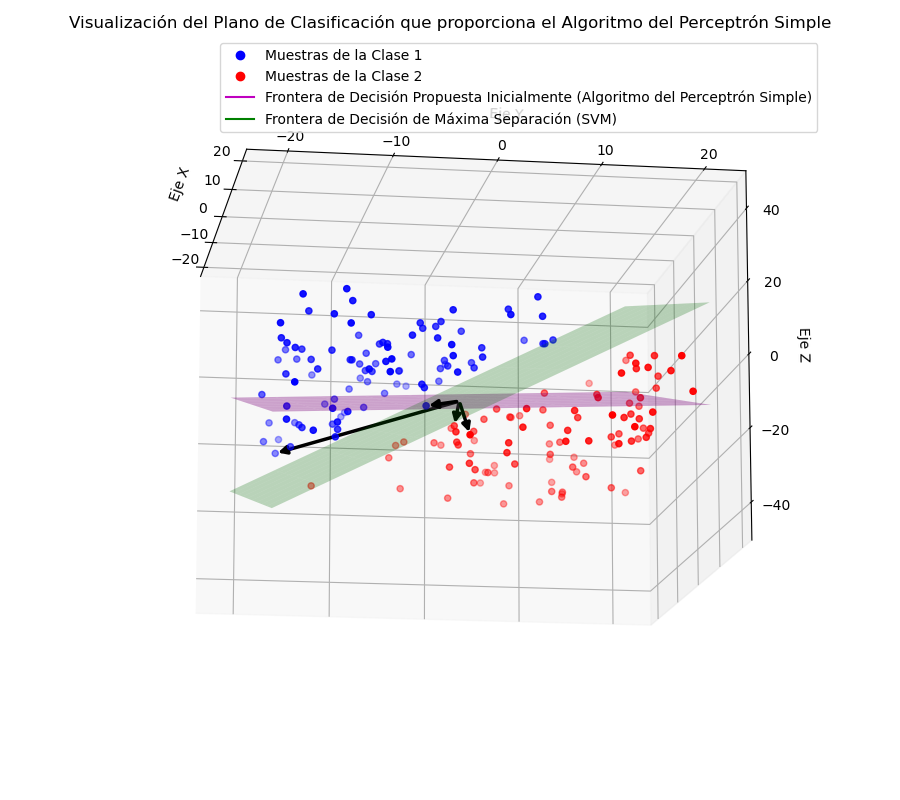

/tmp/ipykernel_13347/994085310.py:107: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [10]:
%matplotlib notebook

listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
valoresCoordenadasYPuntosClase1 = None
valoresCoordenadasYPuntosClase2 = None
valoresCoordenadasZPuntosClase1 = None
valoresCoordenadasZPuntosClase2 = None
minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
minimoEjeY = None
maximoEjeY = None
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoClasificacion = 10
if numeroDimensiones == 1:
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    
    plt.figure(num = 1, figsize = (9, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 1], color = 'm', linestyle = '-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.axvline(x = -listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión de Máxima Separación (SVM)", linewidth = 2.5)
    for vector in listaVectoresSoporte:
        plt.arrow(0, 0, vector[numeroDimensiones - 1], 0.0, head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
    
    listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

    plt.figure(num = 1, figsize = (9, 8))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'm-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)")
    plt.plot(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, 'g-', label = "Frontera de Decisión de Máxima Separación (SVM)")
    for vector in listaVectoresSoporte:
        plt.arrow(0, 0, vector[numeroDimensiones - 2], vector[numeroDimensiones - 1], head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima)
        listaValoresCoordenadaZHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
        listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]
    elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
        listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(num = 1, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 10, azim = -40)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'm', alpha = 0.35)
    etiquetaLeyendaPlanoBase = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'm')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima, color = 'g', alpha = 0.25)
    etiquetaLeyendaPlanoSeparacionMaxima = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    for vector in listaVectoresSoporte:
        flechaVector = Arrow3D([0.0, vector[numeroDimensiones - 3]], [0.0, vector[numeroDimensiones - 2]], [0.0, vector[numeroDimensiones - 1]], mutation_scale = 12, lw = 2.5, arrowstyle = "-|>", color = "k")
        ax.add_artist(flechaVector)
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlanoBase, etiquetaLeyendaPlanoSeparacionMaxima], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", "Frontera de Decisión de Máxima Separación (SVM)"], numpoints = 1)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


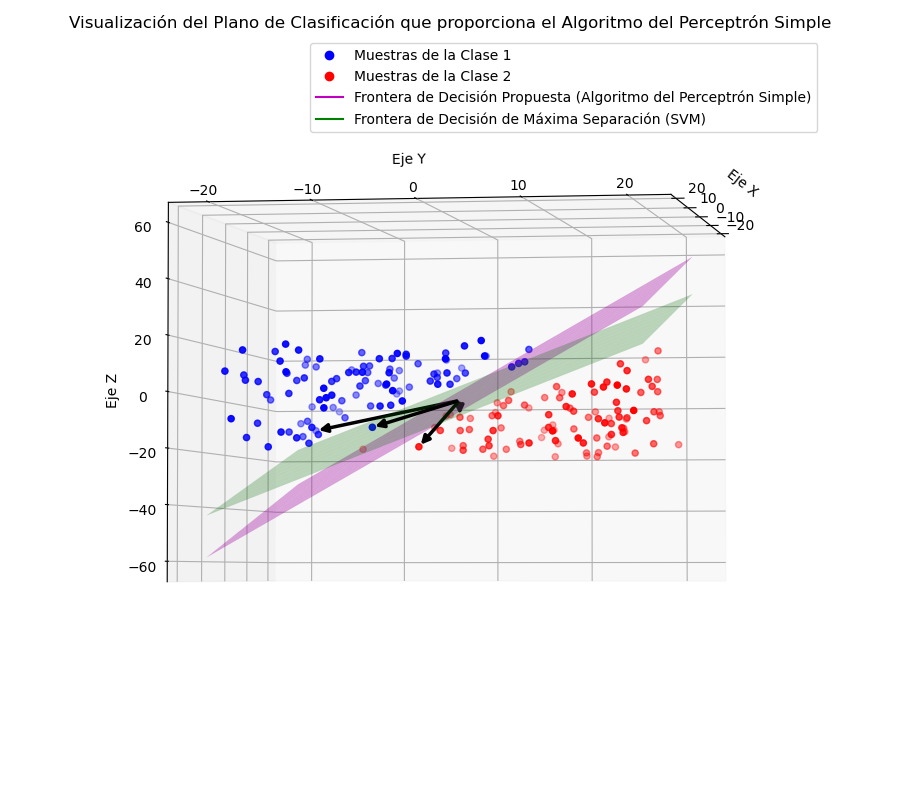

/tmp/ipykernel_13347/1977189603.py:133: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [11]:
listaCoeficientesHiperplanoSeparacion, numeroPasos = algoritmoPerceptronSimple(listaCoeficientesHiperplanoBase, listaCoeficientesHiperplanoSeparacionMaxima, listaVectoresSoporte, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones)

In [12]:
textoEcuacionHiperplanoSeparacion = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoSeparacion, numeroDimensiones)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("La recta obtenida al ejecutar el algoritmo del perceptrón simple, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano obtenido al ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano obtenido al ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")

display(Math(textoEcuacionHiperplanoSeparacion))

El plano obtenido al ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:


<IPython.core.display.Math object>

In [13]:
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("Al ejecutar el algoritmo del perceptrón simple, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar una recta que separe perfectamente los puntos de muestra de las 2 clases")
elif numeroDimensiones == 3:
    print("Al ejecutar el algoritmo del perceptrón simple, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar un plano que separe perfectamente los puntos de muestra de las 2 clases")
elif numeroDimensiones >= 4:
    print("Al ejecutar el algoritmo del perceptrón simple, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar un hiperplano que separe perfectamente los puntos de muestra de las 2 clases")

endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución: {} minutos y {} segundos".format(runningTimeInMinutes, runningTimeInSeconds))

Al ejecutar el algoritmo del perceptrón simple, se requirió de 261 paso(s) para encontrar un plano que separe perfectamente los puntos de muestra de las 2 clases
Tiempo de Ejecución: 0 minutos y 12 segundos
